In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 1. Import Dataset

In [2]:
from torch.utils.data import DataLoader
from poc_data_v2 import PocDataset, display_sample


NUM_CASES = 2**10
BATCH_SIZE = 2**5

poc_raw_dataset = PocDataset(num_cases=NUM_CASES)
data_loader = DataLoader(dataset=poc_raw_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        pin_memory=True)

batch_data, batch_data_length, batch_event = next(iter(data_loader))

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)

torch.Size([32, 36, 5])
torch.Size([32, 1])
torch.Size([32, 1])


### Data Exploration

Length is 30, Event is 1
Length is 36, Event is 2
Length is 5, Event is 1
Length is 10, Event is 0


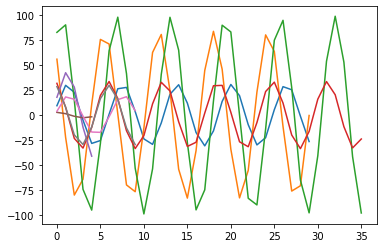

In [3]:
#Take a look at the longitudional data
display_sample(batch_data[0], batch_data_length[0], batch_event[0])
display_sample(batch_data[1], batch_data_length[1], batch_event[1])
display_sample(batch_data[2], batch_data_length[2], batch_event[2])
display_sample(batch_data[3], batch_data_length[3], batch_event[3])

### Test Sample

Length is 36, Event is 2


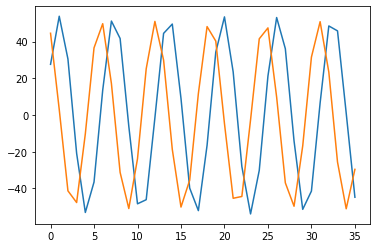

In [4]:
test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = DataLoader(dataset=test_poc_raw_dataset,batch_size=1,pin_memory=True)
test_batch_data, test_batch_data_length, test_batch_event = next(iter(test_data_loader))
display_sample(test_batch_data[0], test_batch_data_length[0], test_batch_event[0])

# 2. Hyperparameters

In [5]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork, DynamicDeepHit
from losses_v2 import loss_1_batch, loss_2_batch, loss_3_batch

NUM_EPOCHS = 250

LEARNING_RATE_ENCODER = 0.0001
LEARNING_RATE_DECODER = 0.0001
LEARNING_RATE_CAUSESS = 0.00005

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 0
LOSS_3_AMPLIFIER = 0

RUN_VALIDATION_ROUND = False
VAL_NUM_CASES_RUNTIME = 2**3

input_size = 5
output_size = input_size
MAX_LENGTH = 36
NUM_CAUSES = 2
hidden_size_encoder = 512
hidden_size_attention = 512
fc_size_encoder = 512
SIGMA = 1

# 3. Defining The Model

In [6]:
# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, hidden_size_attention, output_size).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DDHT = DynamicDeepHit(encoder, decoder, causess, MAX_LENGTH, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)
 
# initialize loss
writer = SummaryWriter()

# 4. Training the model

In [7]:
from torch import autograd

# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for batch_number, data in enumerate(test_data_loader):

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()
    optimizer_causess.zero_grad()

    batch_data, batch_data_length, batch_event = data
    batch_data = batch_data.to(DEVICE)
    batch_data_length = batch_data_length.to(DEVICE)
    batch_event = batch_event.to(DEVICE)
    
    output_batch, first_hitting_time_batch = DDHT(batch_data, batch_data_length)

    loss1 = LOSS_1_AMPLIFIER*loss_1_batch(first_hitting_time_batch, batch_event, batch_data_length, MAX_LENGTH)
    loss2 = LOSS_2_AMPLIFIER*loss_2_batch(first_hitting_time_batch, batch_event, batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)
    loss3 = LOSS_3_AMPLIFIER*loss_3_batch(output_batch, batch_data.detach())

    batch_loss = loss1 + loss2 + loss3
    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    writer.add_scalar('train_loss1', loss1.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss2', loss2.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss3', loss3.item(), epoch*len(data_loader) + batch_number)

    optimizer_encoder.step()
    optimizer_decoder.step()
    optimizer_causess.step()

  if RUN_VALIDATION_ROUND:
    # validating round
    DDHT.eval()

    with torch.no_grad():
      val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES_RUNTIME)
      val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=VAL_NUM_CASES_RUNTIME)
      val_batch_data, val_data_length, val_batch_event = next(iter(val_data_loader))
      val_batch_data = val_batch_data.to(DEVICE)
      val_data_length = val_data_length.to(DEVICE)
      val_batch_event = val_batch_event.to(DEVICE)

      val_output_batch, val_first_hitting_time_batch = DDHT(val_batch_data, val_data_length)

      val_loss1 = LOSS_1_AMPLIFIER*loss_1_batch(val_first_hitting_time_batch, val_batch_event, val_data_length, MAX_LENGTH)/VAL_NUM_CASES_RUNTIME
      val_loss2 = LOSS_2_AMPLIFIER*loss_2_batch(val_first_hitting_time_batch, val_batch_event, val_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
      val_loss3 = LOSS_3_AMPLIFIER*loss_3_batch(val_output_batch, val_batch_data.detach())/VAL_NUM_CASES_RUNTIME

      writer.add_scalar('val_loss1', val_loss1.item(), epoch)
      writer.add_scalar('val_loss2', val_loss2.item(), epoch)
      writer.add_scalar('val_loss3', val_loss3.item(), epoch)
      writer.add_scalar('val_epoch_loss', val_loss1.item() + val_loss2.item() + val_loss3.item(), epoch)

    DDHT.train()
    # end validating round

  writer.add_scalar('train_epoch_loss', epoch_loss.item(), epoch)
  


  0%|          | 2/1000 [00:00<04:51,  3.43it/s]

numerator= tensor(0.0253, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0253, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0231, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0231, device='cuda:0', grad_fn=<RsubBackward1>)


  0%|          | 4/1000 [00:00<03:53,  4.27it/s]

numerator= tensor(0.0211, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0211, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0194, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0194, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

  0%|          | 5/1000 [00:00<03:13,  5.14it/s]

 tensor(0.0179, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0179, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0165, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0165, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= 

  1%|          | 8/1000 [00:01<02:25,  6.83it/s]

tensor(0.0154, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0154, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0143, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0143, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

  1%|          | 10/1000 [00:01<02:13,  7.42it/s]

 tensor(0.0133, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0133, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0124, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0124, device='cuda:0', grad_fn=<RsubBackward1>)


  1%|          | 11/1000 [00:01<02:09,  7.65it/s]

numerator= tensor(0.0115, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0115, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0106, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0106, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= 

  1%|▏         | 13/1000 [00:01<02:00,  8.18it/s]

tensor(0.0098, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0098, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0090, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0090, device='cuda:0', grad_fn=<RsubBackward1>)


  2%|▏         | 15/1000 [00:01<02:01,  8.14it/s]

numerator= tensor(0.0083, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0083, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0076, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0076, device='cuda:0', grad_fn=<RsubBackward1>)


  2%|▏         | 17/1000 [00:02<01:59,  8.21it/s]

numerator= tensor(0.0069, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0069, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0063, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0063, device='cuda:0', grad_fn=<RsubBackward1>)


  2%|▏         | 20/1000 [00:02<01:50,  8.83it/s]

numerator= tensor(0.0057, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0057, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0051, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0051, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= 

  2%|▏         | 22/1000 [00:02<01:42,  9.53it/s]

tensor(0.0045, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0045, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0040, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0040, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0035, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= 

  2%|▏         | 24/1000 [00:02<01:34, 10.29it/s]

tensor(0.0035, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0031, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0031, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0027, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0027, device='cuda:0', grad_fn=<RsubBackward1>)


  3%|▎         | 26/1000 [00:02<01:30, 10.71it/s]

numerator= tensor(0.0023, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0023, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0020, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0020, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

  3%|▎         | 28/1000 [00:03<01:33, 10.44it/s]

 tensor(0.0017, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0017, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0014, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0014, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0011, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0011, device='cuda:0', grad_fn=<RsubBackward1>)


  3%|▎         | 32/1000 [00:03<01:25, 11.33it/s]

numerator= tensor(0.0009, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0009, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0007, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0007, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0006, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0006, device='cuda:0', grad_fn=<RsubBackward1>)


  3%|▎         | 34/1000 [00:03<01:24, 11.48it/s]

numerator= tensor(0.0005, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0005, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0004, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0004, device='cuda:0', grad_fn=<RsubBackward1>)


  4%|▎         | 36/1000 [00:03<01:33, 10.31it/s]

numerator= tensor(0.0003, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0003, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0002, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0002, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(0.0001, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0001, device='cuda:0', grad_fn=<RsubBackward1>)


  4%|▍         | 40/1000 [00:04<01:25, 11.23it/s]

numerator= tensor(0.0001, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0.0001, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(7.1858e-05, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(7.1943e-05, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.8912e-05, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(4.8935e-05, device='cuda:0', grad_fn=<RsubBackward1>)


  4%|▍         | 42/1000 [00:04<01:22, 11.58it/s]

numerator= tensor(3.2575e-05, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(3.2544e-05, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.1160e-05, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(2.1219e-05, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.3221e-05, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.3232e-05, device='cuda:0', grad_fn=<RsubBackward1>)


  5%|▍         | 46/1000 [00:04<01:21, 11.69it/s]

numerator= tensor(8.1106e-06, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(8.0466e-06, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.8194e-06, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(4.7684e-06, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.7778e-06, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(2.7418e-06, device='cuda:0', grad_fn=<RsubBackward1>)


  5%|▌         | 50/1000 [00:05<01:19, 11.95it/s]

numerator= tensor(1.5557e-06, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.4901e-06, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.4812e-07, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(8.3447e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.5580e-07, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(4.7684e-07, device='cuda:0', grad_fn=<RsubBackward1>)


  5%|▌         | 52/1000 [00:05<01:20, 11.83it/s]

numerator= tensor(2.4275e-07, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(2.3842e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.3066e-07, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(7.2129e-08, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


  6%|▌         | 56/1000 [00:05<01:18, 12.02it/s]

numerator= tensor(3.9967e-08, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.3115e-08, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.3665e-08, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


  6%|▌         | 58/1000 [00:05<01:18, 12.07it/s]

numerator= tensor(8.4833e-09, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(5.3442e-09, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.4977e-09, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


  6%|▌         | 60/1000 [00:05<01:19, 11.89it/s]

numerator= tensor(2.3475e-09, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.6307e-09, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.1755e-09, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


  6%|▋         | 64/1000 [00:06<01:17, 12.14it/s]

numerator= tensor(8.5541e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(6.4001e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.9835e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


  7%|▋         | 66/1000 [00:06<01:17, 12.07it/s]

numerator= tensor(3.8780e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.0936e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.5384e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


  7%|▋         | 70/1000 [00:06<01:16, 12.15it/s]

numerator= tensor(2.1323e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.7868e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.5409e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


  7%|▋         | 72/1000 [00:06<01:19, 11.72it/s]

numerator= tensor(1.3254e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.1802e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

  7%|▋         | 74/1000 [00:07<01:26, 10.75it/s]

 tensor(1.0489e-10, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(9.4725e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

  8%|▊         | 76/1000 [00:07<01:25, 10.77it/s]

 tensor(8.5518e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(7.8118e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


  8%|▊         | 78/1000 [00:07<01:32,  9.99it/s]

numerator= tensor(7.2369e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(6.6842e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


  8%|▊         | 80/1000 [00:07<01:33,  9.89it/s]

numerator= tensor(6.2594e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(5.9052e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

  8%|▊         | 82/1000 [00:07<01:31, 10.03it/s]

 tensor(5.5468e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(5.2952e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


  8%|▊         | 84/1000 [00:08<01:31,  9.99it/s]

numerator= tensor(5.0465e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.8420e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

  9%|▊         | 86/1000 [00:08<01:33,  9.79it/s]

 tensor(4.7244e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.4828e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

  9%|▉         | 88/1000 [00:08<01:32,  9.82it/s]

 tensor(4.3601e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.2326e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


  9%|▉         | 91/1000 [00:08<01:31,  9.95it/s]

numerator= tensor(4.1764e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.0528e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.9753e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


  9%|▉         | 93/1000 [00:09<01:31,  9.94it/s]

numerator= tensor(3.8676e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.7881e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.7738e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 10%|▉         | 95/1000 [00:09<01:36,  9.34it/s]

numerator= tensor(3.7393e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.6411e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 10%|▉         | 97/1000 [00:09<01:30,  9.99it/s]

 tensor(3.6205e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.5871e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.5527e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= 

 10%|█         | 101/1000 [00:09<01:23, 10.81it/s]

tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.4786e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.4773e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)


 10%|█         | 103/1000 [00:09<01:22, 10.88it/s]

numerator= tensor(3.3915e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.3740e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 10%|█         | 105/1000 [00:10<01:22, 10.86it/s]

 tensor(3.3488e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.3304e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.3020e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 11%|█         | 107/1000 [00:10<01:19, 11.21it/s]

numerator= tensor(3.3006e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.2522e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.2376e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= 

 11%|█         | 109/1000 [00:10<01:17, 11.53it/s]

tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.1733e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.1654e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 11%|█▏        | 113/1000 [00:10<01:19, 11.22it/s]

numerator= tensor(3.1446e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.1476e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.1228e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 12%|█▏        | 115/1000 [00:11<01:20, 10.97it/s]

numerator= tensor(3.1046e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.0404e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 12%|█▏        | 117/1000 [00:11<01:22, 10.71it/s]

numerator= tensor(3.0480e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.0343e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.9814e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 12%|█▏        | 121/1000 [00:11<01:17, 11.28it/s]

numerator= tensor(2.9958e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.9449e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 12%|█▏        | 123/1000 [00:11<01:21, 10.79it/s]

 tensor(2.8960e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.8476e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 12%|█▎        | 125/1000 [00:11<01:22, 10.57it/s]

numerator= tensor(2.8253e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.7509e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 13%|█▎        | 127/1000 [00:12<01:21, 10.70it/s]

 tensor(2.7428e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.6496e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= 

 13%|█▎        | 129/1000 [00:12<01:17, 11.24it/s]

tensor(2.6145e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.5760e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.5077e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 13%|█▎        | 131/1000 [00:12<01:14, 11.69it/s]

numerator= tensor(2.4911e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.4356e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.4111e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 14%|█▎        | 135/1000 [00:12<01:14, 11.66it/s]

numerator= tensor(2.3222e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.2851e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= 

 14%|█▎        | 137/1000 [00:13<01:17, 11.20it/s]

tensor(2.2549e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.2144e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 14%|█▍        | 139/1000 [00:13<01:20, 10.73it/s]

 tensor(2.1513e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.1295e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= 

 14%|█▍        | 141/1000 [00:13<01:19, 10.79it/s]

tensor(2.1007e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.0473e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.0112e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)


 14%|█▍        | 143/1000 [00:13<01:17, 11.12it/s]

numerator= tensor(2.0042e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.9464e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.9065e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 15%|█▍        | 147/1000 [00:13<01:14, 11.47it/s]

numerator= tensor(1.8735e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.8317e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.7948e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 15%|█▍        | 149/1000 [00:14<01:12, 11.76it/s]

numerator= tensor(1.7611e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.7274e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.6968e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 15%|█▌        | 153/1000 [00:14<01:17, 10.90it/s]

numerator= tensor(1.6551e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.6410e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 16%|█▌        | 155/1000 [00:14<01:19, 10.63it/s]

 tensor(1.6054e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.5806e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 16%|█▌        | 157/1000 [00:14<01:21, 10.38it/s]

 tensor(1.5284e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.5094e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 16%|█▌        | 159/1000 [00:15<01:22, 10.19it/s]

numerator= tensor(1.4759e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.4337e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)


 16%|█▌        | 161/1000 [00:15<01:21, 10.30it/s]

numerator= tensor(1.4303e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.3892e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.3710e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 16%|█▋        | 163/1000 [00:15<01:19, 10.52it/s]

numerator= tensor(1.3331e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.3135e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.2789e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 17%|█▋        | 167/1000 [00:15<01:11, 11.64it/s]

numerator= tensor(1.2699e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.2402e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.2200e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)


 17%|█▋        | 171/1000 [00:16<01:08, 12.09it/s]

numerator= tensor(1.1994e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.1624e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.1465e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 17%|█▋        | 173/1000 [00:16<01:07, 12.22it/s]

numerator= tensor(1.1237e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.1140e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.0890e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 18%|█▊        | 175/1000 [00:16<01:07, 12.17it/s]

numerator= tensor(1.0707e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.0409e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.0319e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 18%|█▊        | 179/1000 [00:16<01:06, 12.43it/s]

numerator= tensor(1.0104e-11, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(9.9624e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(9.7122e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 18%|█▊        | 181/1000 [00:16<01:12, 11.25it/s]

numerator= tensor(9.5917e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(9.4635e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 18%|█▊        | 183/1000 [00:17<01:13, 11.17it/s]

 tensor(9.1682e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(9.0838e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.9229e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 19%|█▊        | 187/1000 [00:17<01:12, 11.14it/s]

numerator= tensor(8.7392e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.6188e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.4660e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 19%|█▉        | 191/1000 [00:17<01:12, 11.13it/s]

numerator= tensor(8.2973e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.1950e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.0915e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)


 19%|█▉        | 193/1000 [00:17<01:10, 11.50it/s]

numerator= tensor(7.9158e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(7.7908e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(7.6069e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 20%|█▉        | 197/1000 [00:18<01:05, 12.21it/s]

numerator= tensor(7.3753e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-2.3842e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(7.3774e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(7.1570e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 20%|█▉        | 199/1000 [00:18<01:05, 12.25it/s]

numerator= tensor(7.1014e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(6.9902e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(6.8392e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 20%|██        | 201/1000 [00:18<01:05, 12.24it/s]

numerator= tensor(6.6213e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(6.4616e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(6.3998e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 20%|██        | 205/1000 [00:18<01:05, 12.20it/s]

numerator= tensor(6.2017e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(5.9839e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(5.8885e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 21%|██        | 209/1000 [00:19<01:04, 12.32it/s]

numerator= tensor(5.6727e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(5.5208e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(5.3699e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 21%|██        | 211/1000 [00:19<01:09, 11.33it/s]

numerator= tensor(5.2260e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(5.0364e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 21%|██▏       | 213/1000 [00:19<01:08, 11.50it/s]

 tensor(4.8758e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.7581e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.6272e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 22%|██▏       | 215/1000 [00:19<01:06, 11.74it/s]

numerator= tensor(4.4601e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.3530e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(4.1584e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 22%|██▏       | 219/1000 [00:20<01:09, 11.30it/s]

numerator= tensor(4.0482e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.9577e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 22%|██▏       | 221/1000 [00:20<01:13, 10.65it/s]

 tensor(3.7717e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.7067e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 22%|██▏       | 223/1000 [00:20<01:14, 10.38it/s]

 tensor(3.5799e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.4391e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 22%|██▎       | 225/1000 [00:20<01:11, 10.81it/s]

 tensor(3.3540e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.3085e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(3.1995e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 23%|██▎       | 227/1000 [00:20<01:11, 10.88it/s]

numerator= tensor(3.0865e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.9587e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.9161e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 23%|██▎       | 231/1000 [00:21<01:11, 10.80it/s]

numerator= tensor(2.8653e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.7638e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= 

 23%|██▎       | 233/1000 [00:21<01:09, 11.05it/s]

tensor(2.6519e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.6219e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.5854e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 24%|██▎       | 235/1000 [00:21<01:11, 10.68it/s]

numerator= tensor(2.4726e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.4411e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

 24%|██▎       | 237/1000 [00:21<01:10, 10.82it/s]

 tensor(2.3489e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.2934e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.2504e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 24%|██▍       | 241/1000 [00:22<01:07, 11.31it/s]

numerator= tensor(2.1870e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.1494e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(2.0964e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 24%|██▍       | 243/1000 [00:22<01:06, 11.38it/s]

numerator= tensor(2.0374e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.9997e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.9672e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 25%|██▍       | 247/1000 [00:22<01:03, 11.78it/s]

numerator= tensor(1.9135e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.8725e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.8560e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 25%|██▍       | 249/1000 [00:22<01:04, 11.63it/s]

numerator= tensor(1.7999e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.7458e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.7193e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 25%|██▌       | 253/1000 [00:23<01:04, 11.57it/s]

numerator= tensor(1.6769e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.6402e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.6123e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= 

 26%|██▌       | 255/1000 [00:23<01:03, 11.79it/s]

tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.5762e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.5477e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 26%|██▌       | 257/1000 [00:23<01:02, 11.82it/s]

numerator= tensor(1.5214e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.4900e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.4703e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 26%|██▌       | 261/1000 [00:23<01:05, 11.35it/s]

numerator= tensor(1.4332e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.4212e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 26%|██▋       | 263/1000 [00:24<01:06, 11.16it/s]

numerator= tensor(1.3923e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.3694e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.3420e-12, device='cuda:0', grad_fn=<SumBackward0>)

 26%|██▋       | 265/1000 [00:24<01:05, 11.20it/s]


denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.3105e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.2857e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 27%|██▋       | 267/1000 [00:24<01:03, 11.54it/s]

numerator= tensor(1.2631e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.2615e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.2302e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 27%|██▋       | 271/1000 [00:24<01:00, 12.01it/s]

numerator= tensor(1.2077e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.1811e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.1788e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 28%|██▊       | 275/1000 [00:25<00:59, 12.26it/s]

numerator= tensor(1.1364e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.1042e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.0828e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 28%|██▊       | 277/1000 [00:25<00:57, 12.49it/s]

numerator= tensor(1.0609e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.0488e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(1.0129e-12, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 28%|██▊       | 281/1000 [00:25<00:56, 12.64it/s]

numerator= tensor(9.9015e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(9.6653e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-2.3842e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(9.4397e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 28%|██▊       | 283/1000 [00:25<00:57, 12.48it/s]

numerator= tensor(9.2032e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.9809e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.7774e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)


 28%|██▊       | 285/1000 [00:25<00:57, 12.51it/s]

numerator= tensor(8.4971e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.3590e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.2935e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= 

 29%|██▊       | 287/1000 [00:26<00:58, 12.18it/s]

tensor(-1.1921e-07, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(8.0488e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(5.9605e-08, device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(7.9051e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)


 29%|██▉       | 291/1000 [00:26<00:59, 11.92it/s]

numerator= tensor(7.7052e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator= tensor(7.5522e-13, device='cuda:0', grad_fn=<SumBackward0>)
denomerator= tensor(0., device='cuda:0', grad_fn=<RsubBackward1>)
numerator=

# 4. Testing the Model

### Predicting the test sample

In [ ]:
PATH = "C:/Users/marij/Desktop/THESIS ECO/DDHT/DDHT_pytorch/models/model_4.pth"
#torch.save(DDHT.state_dict(), PATH)
#DDHT.load_state_dict(torch.load(PATH))

Length is 12, Event is 2
tensor([[  4.8699,  42.5311],
        [ 20.8210,   4.3782],
        [ 17.6294, -37.8000],
        [ -1.7706, -45.2250],
        [-19.5427, -11.0704]])


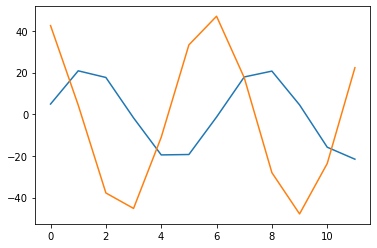

In [ ]:
display_sample(test_batch_data[0], test_batch_data_length[0], test_batch_event[0])
print(test_batch_data[0,:5,3:])

tensor([[ 0.0976, -0.0297],
        [ 0.0514, -0.0080],
        [ 0.0040,  0.0047],
        [ 0.0047,  0.0095],
        [ 0.0213,  0.0303]], device='cuda:0', grad_fn=<SliceBackward>)
the model predicts at time 33 the event 1


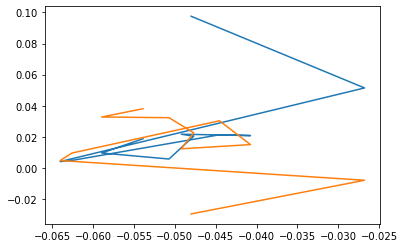

In [ ]:
DDHT.eval();
test_encoder_output_vector, test_first_hitting_time = DDHT(test_batch_data.to(DEVICE), test_batch_data_length.to(DEVICE))
display_sample(test_encoder_output_vector[0].detach(), test_batch_data_length[0] - 1, test_batch_event[0], mute=True)
print(test_encoder_output_vector[0,:5,3:])

test_first_hitting_time_argmax = test_first_hitting_time.argmax().item()
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH
print("the model predicts at time %d the event %d" % (model_tte_prediction, model_event_prediction))

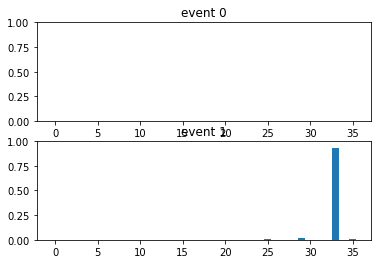

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[:MAX_LENGTH].cpu().detach().numpy())
ax2.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[MAX_LENGTH:].cpu().detach().numpy())
ax1.set_title("event 0")
ax2.set_title("event 1")
ax1.set_ylim([0,1]);
ax2.set_ylim([0,1]);

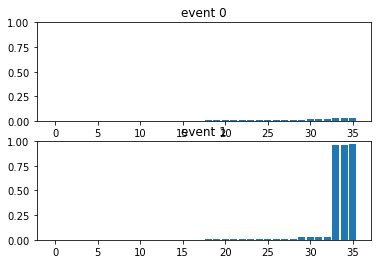

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[:MAX_LENGTH], dim=0).cpu().detach().numpy())
ax2.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[MAX_LENGTH:], dim=0).cpu().detach().numpy())
ax1.set_title("event 0")
ax2.set_title("event 1")
ax1.set_ylim([0,1]);
ax2.set_ylim([0,1]);

### Scoring our model

In [ ]:
VAL_NUM_CASES = 2**6

val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES)
val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=2**6)
val_input_batch, val_event_batch, val_time_to_event_batch, _ = next(iter(val_data_loader))
val_input_batch = val_input_batch.to(DEVICE)
val_event_batch = val_event_batch.to(DEVICE)
val_time_to_event_batch = val_time_to_event_batch.to(DEVICE)


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
DDHT.eval()

val_output_batch, val_first_hitting_time_batch = DDHT(val_input_batch, val_time_to_event_batch)
val_loss1 = loss_1_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, MAX_LENGTH)/VAL_NUM_CASES
val_loss2 = loss_2_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES
val_loss3 = loss_3_batch(val_output_batch, val_input_batch.detach())/VAL_NUM_CASES


print("val_loss1=", val_loss1.item())
print("val_loss2=", val_loss2.item())
print("val_loss3=", val_loss3.item())


Records:
val_loss1= 0.09860126674175262
val_loss2= 16.080060958862305
val_loss3= 690.994384765625

In [ ]:
PATH = "C:/Users/marij/Desktop/THESIS ECO/DDHT/DDHT_pytorch/models/model_3.pth"
torch.save(DDHT.state_dict(), PATH)